In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [3]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [6]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [7]:
pv = pv.set_index('datetime')

In [112]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,21,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,15,00,tzinfo=tz):]

In [113]:
# pv_test.loc[datetime(2006,12,30,00,tzinfo=tz):, 'power_scale'] = 0

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [114]:
from torch.utils.data import DataLoader, Dataset

In [115]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, feature)
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

In [116]:
iw = 24*7
ow = 24
num_feature = 5

train_dataset = windowDataset(pv_train[['power_scale', 'dwpt', 'rhum', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
test_dataset = windowDataset(pv_test[['power_scale', 'dwpt', 'rhum', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)

train_loader = DataLoader(train_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=1)

In [117]:
len(train_loader)

22

In [118]:
len(test_loader)

10

# model

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import tqdm
import random

In [120]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [147]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=24*8):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [148]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_encoder_layers=1, dim_feedforward=128): # num_layers: lstm layer 수
        super(TransformerModel, self).__init__() 
        self.input_size = input_size
        self.num_encoder_layers = num_encoder_layers
        self.dim_feedforward = dim_feedforward
        self.pos_encoder = PositionalEncoding(d_model=self.input_size, dropout=0.1)

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.transformer = nn.TransformerEncoderLayer(d_model=self.input_size, nhead=self.input_size, dim_feedforward=self.dim_feedforward, batch_first=True) 
        self.linear = nn.Linear(self.input_size, 1)

    def forward(self, src, src_mask):
        src = self.pos_encoder(src)
        out = self.transformer(src, src_mask=src_mask)
        output = self.linear(out)
        return output

In [149]:
def train(epochs, src_mask):
    model.train()

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        total_loss = 0.0

        for x, y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            # y_temp = torch.zeros_like(y)
            input = torch.cat((x, y), dim=1)
            output = model(input, src_mask=src_mask)
            loss = criterion(output[:,(24*7):,0].unsqueeze(2), y[:,:,0].unsqueeze(2))
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        pbar.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

    return output[:,(24*7):,:].detach().cpu().numpy(), y.detach().cpu().numpy()

In [150]:
def predict(test_loader, src_mask, file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    for t, (x, y) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y = y.to(device).float()
        # y_temp = torch.zeros_like(y)
        input = torch.cat((x, y), dim=1)
        output = model(input, src_mask=src_mask)
        outputs.append(list(output[:,(24*7):,0].detach().cpu().numpy()))
        ys.append(list(y[:,:,0].detach().cpu().numpy()))
        loss = criterion(output[:,(24*7):,0], y[:,:,0])
        total_loss += loss.cpu().item()

    print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[]))

In [151]:
device='cuda'

# model = nn.Transformer(d_model=4, nhead=4, num_encoder_layers=1, num_decoder_layers=6, dim_feedforward=128, batch_first=True).to(device)
model = TransformerModel(input_size=5).to(device)

RuntimeError: ignored

In [141]:
learning_rate=0.001
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [126]:
src_mask1 = torch.Tensor(24*8, 24*7).fill_(1)
src_mask2 = torch.Tensor(24*8, 24).fill_(0)
src_mask = torch.cat((src_mask1, src_mask2), dim=1).to(device)
src_mask = src_mask.float().masked_fill(src_mask == 0, float('-inf')).masked_fill(src_mask == 1, float(0.0))

In [127]:
pred, true = train(epoch, src_mask=src_mask)

  0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
pred, true = predict(test_loader, src_mask)

test loss: 0.00349


In [129]:
pred = power_scaler.inverse_transform(pred.reshape(-1,1))
real = power_scaler.inverse_transform(true.reshape(-1,1))

In [130]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):]

In [131]:
pred.shape

(240, 1)

In [132]:
pv_test.shape

(240, 19)

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


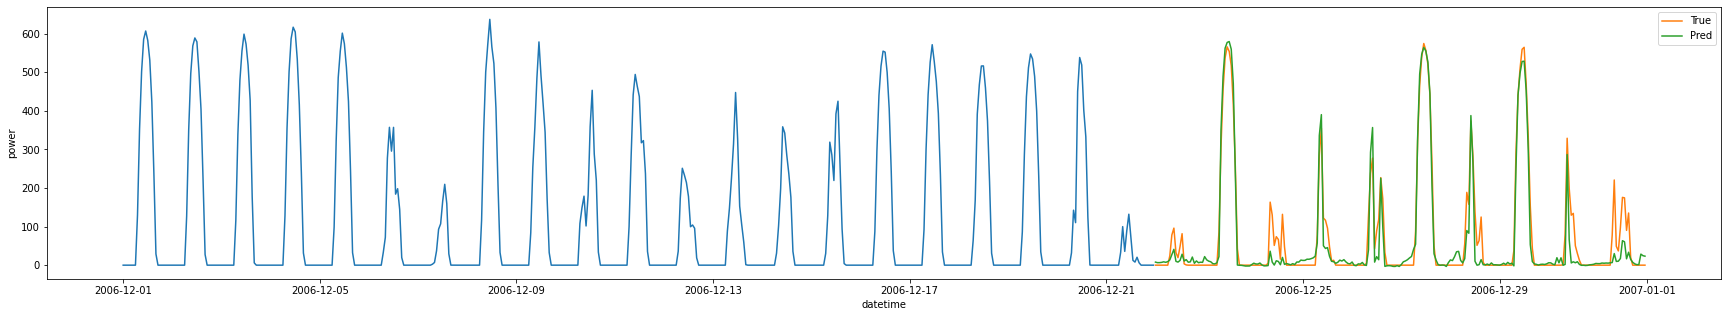

In [134]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, real.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()